<a href="https://colab.research.google.com/github/clairecoffey/project/blob/master/copy_claire_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness and the bias-variance trade-off 

## June 2020

In this notebook we are studying bias and variance errors in the context of fairness, by exploring recidivism data. 

## Imports and Setup

Imports: first import the relevant libraries used throughout. 

In [0]:
from sklearn import svm
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd

# Read in recidivism data 

In this notebook we are studying recidivism data. We utilise the COMPAS recidivism dataset, which uses recidivism data from Broward County jail and has been explored in the following studies:

"The accuracy, fairness, and limits of predicting recidivism", paper available at:
https://advances.sciencemag.org/content/4/1/eaao5580#corresp-1

"Machine Bias" ProPublica article, available at:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

The dataset used can be found at:
https://github.com/propublica/compas-analysis


Here we import and read in the recidivism data. Currently, we are using a selection of 2000 samples from this dataset for our predictions.

We use a selection of features from this dataset to predict recidivism classification (1 = will reoffend; 0 = will not reoffend). 

In [0]:
file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/2000-compas-scores-2-years.csv"

# load CSV contents
all_data = pd.read_csv(file_path, delimiter=',', dtype={'sex': 'category', 
                                                        'age_cat': 'category',
                                                        'race': 'category',
                                                        'c_charge_degree': 'category',
                                                        'c_charge_desc': 'category',
                                                        'r_charge_degree': 'category',
                                                        'r_charge_desc': 'category',
                                                        'vr_charge_degree': 'category',
                                                        'vr_charge_desc': 'category'
                                                        })

## Import and process data


We import the data into a pandas DataFrame. We begin by cleaning the data, so the crime descriptions are simplified, removing duplicate categories. For example, we merge descriptions such as 'possession of cocaine' and 'possess cocaine', or 'burglary/weapon' and 'burglary and weapon', by removing prepositions, and replacing abreviations and similies. 

Then,  the categorical data is  split into different fields for each category, and encoded as 0 or 1. For example, an individual with characteristic "sex: male" would be encoded as "male: 1, female: 0". The sex category is then removed.

We then consider which fields to use for prediction. This includes the removal of any fields/columns which contain many NaN values, since these cannot be handled by the classifiers. We choose to remove the columns with many NaNs rather than using an alternative approach such as replacing them with the average so as not to introduce other types of bias. We also then remove rows/individuals containing any further NaN values so there is no longer any NaN values present in the data. 

We then normalise all of the data in the dataframe, so that when fed into the classifier, the predicitons are not skewed (and potentially different forms of bias introduced).  We do this by using the StandardScaler in the sklearn preprocessing library, and we normalise the data to have a variance of 1.

Finally, we define the number of testing/training samples desired and split the data into these two sets appropriately.


In [0]:
num_testing_samples = 1600


In [0]:
def clean_descriptions(description):
  description = description.replace(' and ', ' ')
  description = description.replace(' / ', ' ')
  description = description.replace('possession', 'posess')
  description = description.replace('possessing', 'posess')
  description = description.replace('with', 'w/')
  description = description.replace('w/ ', 'w/')
  description = description.replace('w/', ' ')
  description = description.replace('attempted', 'att')
  description = description.replace('attempt', 'att')
  description = description.replace('aggravated', 'agg')
  description = description.replace('aggrav', 'agg') 
  description = description.replace(' of ', ' ')
  return description

In [0]:
from sklearn import preprocessing

encoded_sex = (pd.get_dummies(all_data['sex']))
all_data = all_data.drop(columns=['sex'])
all_data = all_data.join(encoded_sex)

encoded_age_cat = (pd.get_dummies(all_data['age_cat']))
all_data = all_data.drop(columns=['age_cat'])
all_data = all_data.join(encoded_age_cat)

encoded_race = (pd.get_dummies(all_data['race']))
all_data = all_data.drop(columns=['race'])
all_data = all_data.join(encoded_race)

encoded_c_charge_degree = (pd.get_dummies(all_data['c_charge_degree']))
all_data = all_data.drop(columns=['c_charge_degree'])
all_data = all_data.join(encoded_c_charge_degree, rsuffix='_c')

#these are joined with suffixes because otherwise columns overlap 
all_data['c_charge_desc'] = all_data['c_charge_desc'].astype(str).str.lower()
all_data['c_charge_desc'] = all_data['c_charge_desc'].apply(clean_descriptions)
encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_desc']))
all_data = all_data.drop(columns=['c_charge_desc'])
all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

encoded_r_charge_degree = (pd.get_dummies(all_data['r_charge_degree']))
all_data = all_data.drop(columns=['r_charge_degree'])
all_data = all_data.join(encoded_r_charge_degree, rsuffix='_r')

all_data['r_charge_desc'] = all_data['r_charge_desc'].astype(str).str.lower()
all_data['r_charge_desc'] = all_data['r_charge_desc'].apply(clean_descriptions)
encoded_r_charge_desc = (pd.get_dummies(all_data['r_charge_desc']))
all_data = all_data.drop(columns=['r_charge_desc'])
all_data = all_data.join(encoded_r_charge_desc, rsuffix='_r')

encoded_vr_charge_degree = (pd.get_dummies(all_data['vr_charge_degree']))
all_data = all_data.drop(columns=['vr_charge_degree'])
all_data = all_data.join(encoded_vr_charge_degree, rsuffix='_vr')

all_data['vr_charge_desc'] = all_data['vr_charge_desc'].astype(str).str.lower()
all_data['vr_charge_desc'] = all_data['vr_charge_desc'].apply(clean_descriptions)
encoded_vr_charge_desc = (pd.get_dummies(all_data['vr_charge_desc']))
all_data = all_data.drop(columns=['vr_charge_desc'])
all_data = all_data.join(encoded_vr_charge_desc, rsuffix='_vr')

all_data = all_data.drop(columns=['nan'])
all_data = all_data.drop(columns=['nan_vr'])
all_data = all_data.drop(columns=['nan_r'])

#drop columns not used for predictions, including info such as names, and columns with many NaN values 
all_data.columns = map(str.lower, all_data.columns)
#dont use individual crimes, too much and too slow, only use severity of crimes and other info
all_data_simplified = all_data[['juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_recid','is_violent_recid','event','female','male','25 - 45','greater than 45','less than 25','african-american','asian','caucasian','hispanic','native american','other','f','m','(f1)','(f2)','(f3)','(f6)','(m1)','(m2)','(mo3)']]

#remove rows containing NaN values 
all_data_simplified = all_data_simplified.dropna()

Normalise data 

In [0]:
#normalise the data so we have unit variance and mean 0 using built-in preprocessing method in sklearn
scaler = preprocessing.StandardScaler()
all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data_simplified),columns=all_data_simplified.columns)

Verify normalisation 

In [0]:
all_data_scaled.mean()

In [0]:
all_data_scaled.var()

In [0]:
all_labels = all_data[['two_year_recid']]
all_data = all_data_scaled
all_data_and_labels = all_data_scaled.join(all_labels)
testing_data_and_labels_orig = all_data_and_labels[:num_testing_samples]
training_data_and_labels_orig = all_data_and_labels[num_testing_samples:]

### Perform PCA 

In [0]:
u,s,v = np.linalg.svd(all_data)

Print principle components

In [11]:
u

array([[-1.88465845e-02, -3.32362847e-02, -2.78257872e-03, ...,
         1.55410446e-03, -5.88367955e-03, -1.17118499e-02],
       [ 3.54222437e-02,  2.73978635e-03,  3.40762841e-03, ...,
        -5.07976701e-03, -4.31404805e-03, -5.62221760e-03],
       [ 2.03485195e-02, -1.57791917e-02, -1.51308789e-02, ...,
         9.55007182e-03,  2.68278050e-03,  1.97477455e-03],
       ...,
       [ 2.01630670e-02, -4.90232847e-03,  5.98261798e-03, ...,
         9.86947799e-01,  1.69207588e-03,  5.55818602e-04],
       [-2.68655221e-02,  2.27823548e-02, -1.02094204e-02, ...,
         1.48369513e-03,  9.95624063e-01,  1.09009693e-03],
       [-1.19853114e-02, -1.78374302e-02,  7.15111930e-03, ...,
         1.72779905e-04,  1.13563829e-03,  9.96930071e-01]])

In [0]:
positive_labels = all_labels['two_year_recid'] == 1
negative_labels = all_labels['two_year_recid'] == 0

Plot all dimensions of PCA

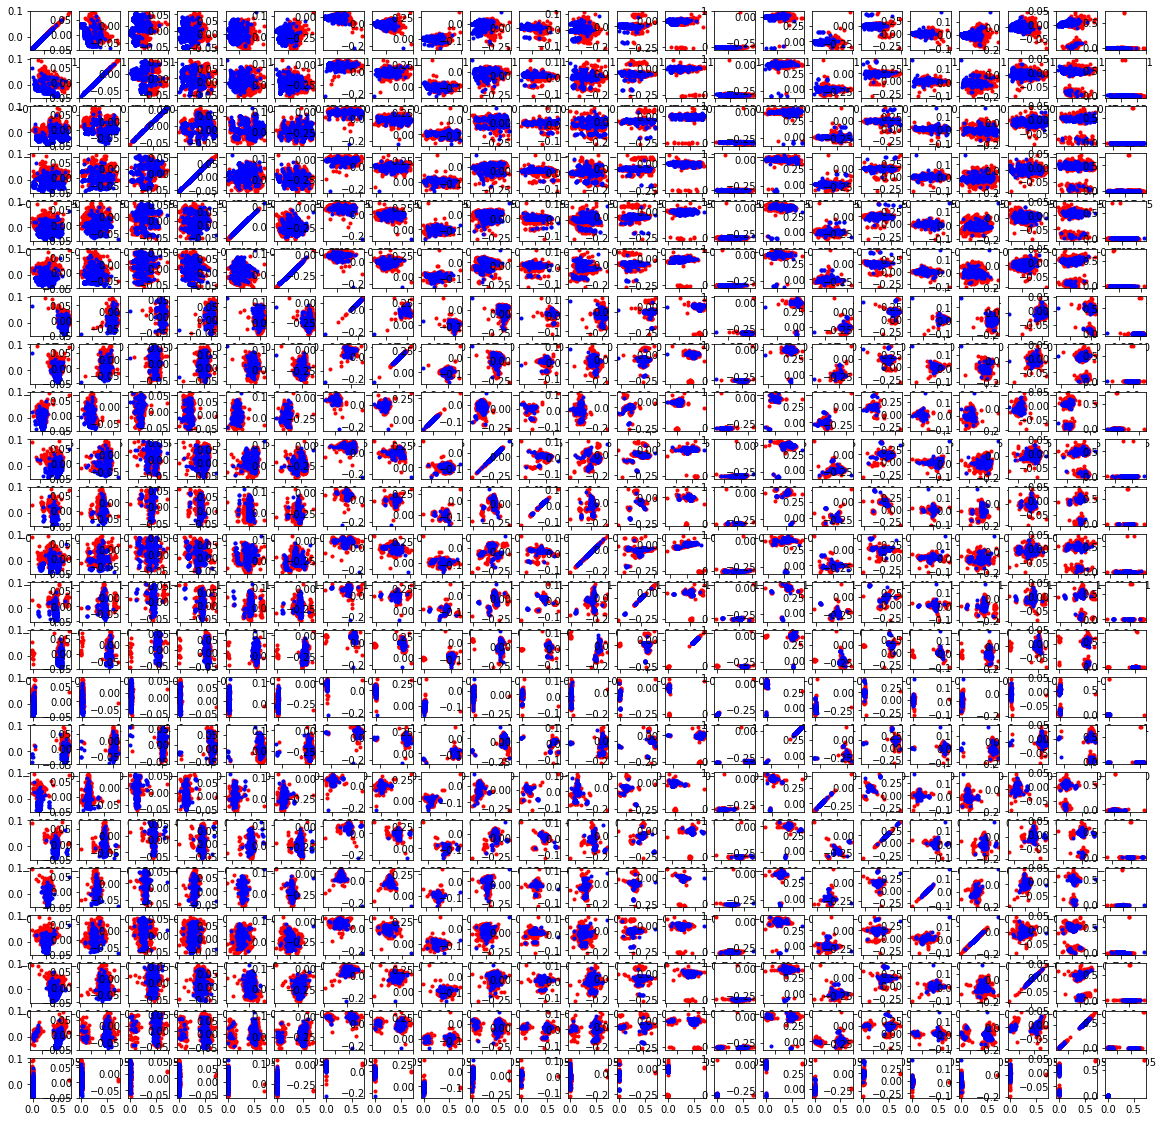

In [14]:
import matplotlib.pyplot as plt                                  
maxpc = 23
fig, ax = plt.subplots(maxpc, maxpc, figsize=(20,20))
for pc1 in range(maxpc):
  for pc2 in range(maxpc):
    ax[pc1,pc2].plot(u[positive_labels,pc1], u[positive_labels, pc2], 'r.')
    ax[pc1,pc2].plot(u[negative_labels,pc1], u[negative_labels, pc2], 'b.')

Plot specific 2 dimensions to visualise data 

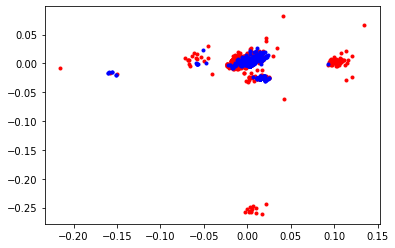

In [15]:
import matplotlib.pyplot as plt                                  
dim1 = 12
dim2 = 13
plt.plot(u[positive_labels,dim1], u[positive_labels,dim2], 'r.')
plt.plot(u[negative_labels,dim1], u[negative_labels,dim2], 'b.')

Select dimensions we want to use to represent our data; define the data based on these

In [0]:
#we want to use 12 and 13th dimensions as features 
dim12 = u[:,12]
dim13 = u[:,13]
all_X_transformed = pd.DataFrame({'dim12':dim12, 'dim13':dim13}, index=all_data.index)
all_X_transformed_and_labels = all_X_transformed.join(all_labels)

In [0]:
training_data_and_labels = all_X_transformed_and_labels[num_testing_samples:]
testing_data_and_labels = all_X_transformed_and_labels[:num_testing_samples]

In [0]:
training_data = all_X_transformed[num_testing_samples:]
training_labels = all_labels[num_testing_samples:]

##Selecting Classifiers

Here we select the classification model to use. We are using a selection of built-in classifiers in scikit-learn. 

Currently, we are using RBF SVM models (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

We define the boolean values ```vary_gamma ``` and  ```vary_c``` to define whether we are varying the gamma or C parameters; C defines the misclassification penalty and gamma defines the spread of the kernel. 



In [0]:
from sklearn import model_selection, neighbors, svm, metrics

vary_gamma = True
vary_c = False 
polynomial = False
gammas = []
cs = []
classifiers = []
degrees = []

if vary_gamma:
  # high bias, variance models
  gammas = [250, 500000]
  #paramter config 
  # gammas = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000, 1000000]
  cs=[1000]

  for gamma_val in gammas:
    for c_val in cs:
      classifiers.append(svm.SVC(gamma=gamma_val,C=c_val, probability=True))

if vary_c:
  cs = [10, 100, 1000, 10000, 100000, 1000000, 10000000, 10000000]
  gamma_val = 1
  #fix size of gamma if varying C
  for c_val in cs:
    classifiers.append(svm.SVC(gamma=gamma_val,C=c_val, probability=True))

if polynomial:
  degrees = [0,1,2,3,4,5,6,7,8]
  # degrees = [0]
  for degree in degrees:
    classifiers.append(svm.SVC(kernel='poly', degree=degree, probability=True))

## Bootstrapping 

The classification process then uses a bootstrapping procedure with the chosen model, to generate predictions of recidivism classifications (1 = will not reoffend (positive case); 0 = will reoffend (negative case)).

Bootstrapping (https://link.springer.com/chapter/10.1007/978-1-4612-4380-9_41) is a sampling with replacement procedure. The sample size is the same as the size of the (training) dataset. The bootstrapping procedure is run many times to generate different training datasets, which will then be used for classification. In turn, the classification results will be used to calculate and study the bias and variance errors. 

In [0]:
def do_bootstrap(training_data_and_labels):
  # this is one bootstrap sample 
  indices = np.random.randint(0,training_data_and_labels.shape[0] , training_data_and_labels.shape[0])
  indices.sort()
  data_points = []

  for i in indices:
    data_points.append(training_data_and_labels.iloc[i])

  b_sample = pd.DataFrame(data_points)
  
  return b_sample

## Perform classification

Fit the model on the training data (which is one bootstrap data sample as defined above)


In [0]:
def fit_and_predict(clf, b_sample, testing_data_and_labels):

    #training data is everything apart from two year recid 0/1 label from the bootstrap sample
    X_train = b_sample.drop(columns=['two_year_recid'])
    y_train = b_sample['two_year_recid']
    X_test = testing_data_and_labels.drop(columns=['two_year_recid'])
    y_test = testing_data_and_labels['two_year_recid']

    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    soft_score = clf.decision_function(X_test)
    y_true = y_test
    
    return y_pred, y_true, soft_score

Perform classification for each bootstrap sample separately, and store these in a DataFrame, to be passed into the bias/variance calculations.
This returns all of the predictions for each individual for each bootstrap sample

Define the number of bootstrap samples as 100


In [0]:
num_bootstraps = 100;

In [0]:
def classify(training_data_and_labels, testing_data_and_labels, clf):
    count = 0

    while count < num_bootstraps:
      b_sample = do_bootstrap(training_data_and_labels)
      y_pred, y_true, soft_score = fit_and_predict(clf, b_sample, testing_data_and_labels)
      # calc_conf_matrix_bootstrap(y_true, y_pred)
      if(count == 0):
        predictions = pd.DataFrame(pd.Series(y_pred)).transpose()
        #true labels are the same for every sample so we only need 1 row in df
        true_labels = pd.DataFrame(pd.Series(y_true)).transpose()
      else:
        predictions = predictions.append(pd.DataFrame(pd.Series(y_pred)).transpose())
      count += 1
      
      
    return predictions, true_labels, soft_score

In [0]:
from sklearn.metrics import confusion_matrix

def calc_conf_matrix(y_true, y_pred):
  # get confusion matrix and compute tn,fp,fn,tp
  tn, fp, fn, tp = confusion_matrix(y_true.iloc[0].to_numpy(), y_pred.iloc[0].to_numpy()).ravel()
  print("true negatives:", tn, "rate:" , tn/(tn+fp+fn+tp), "false positives:", fp, "rate:", fp/(tn+fp+fn+tp) ,"false negatives:", fn,"rate:", fn/(tn+fp+fn+tp), "true positives:",tp,"rate:", tp/(tn+fp+fn+tp))

#Fairness

The definition of fairness is disputed, and there is not a single correct approach to ensuring fairness in machine learning. In general, as stated in https://arxiv.org/pdf/1711.08513.pdf, fairness in machine learning can be approached in two ways: fairness of the dataset itself; fairness of the model.

We will focus on model-based fairness correction - ensuring the machine learning models are not perpetuating existing biases, or introducing new biases. We do this by using a widely used and accepted fairness measurement which is context-independent, known as **Equalised Odds** (http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf). This approach is not without criticism, however it provides a clear and well-motivated approach to achieving fair predictions across subgroups with different protected characteristics. We attempt to correct for fairness in relation to the protected characteristics found in the recidivism dataset (sex, race, age). Once our models are 'fair' in relation to this description, we can explore the relationship between bias and variance errors and the potential discovery of discrimination against new categories. 



##Equalised Odds

As stated above, we are considering fairness in relation to the equalised odds metric (http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf). The definition as stated in this paper is as follows: \\
We say that a predictor $\hat{Y}$ satisfies equalized odds with respect to
protected attribute $A$ and outcome $Y$, if $\hat{Y}$ and $A$ are independent conditional on $Y$. Therefore, if the classification labels are $Y$ and $\hat{Y}$, for an outcome $ y=1 $, $\hat{Y}$ has equal true positive rates across all demographic groups, for example, the categories not female and female will have equal true positive rates. For an outcome  $ y=0 $, $\hat{Y}$ has equal false positive rates across all demographic groups. This enforces equal bias and accuracy in all demographics. This can formally be stated as:
$$ Pr \left\{ \hat{Y}=1 | A = 0, Y = y \right\} = Pr \left\{ \hat{Y}=1 | A = 0, Y = y \right\} , y \in \left\{ 0,1 \right\}$$

This approach punishes models that only perform well on the majority demographics.

The following code is the implementation of equalised odds from the paper http://papers.nips.cc/paper/7151-on-fairness-and-calibration.pdf, the code is from the github repository https://github.com/gpleiss/equalized_odds_and_calibration/blob/master/eq_odds.py.

This implementation equalises false positives and false negatives across demoographics, since in general, African Americans receive
a disproportionate number of F.P. predictions as compared with Caucasians when automated risk tools are used in practice. In the context of recidivism, the 'positive case' is in fact a prediction of 0: the individual is predicted not to reoffend, so equalising false positives in this case fits with the equalised odds definition above.

In [0]:
def calculate_scores(predictions, soft_scores):

  maximum = soft_scores.max()
  minimum = soft_scores.min()
  normalise = lambda x: ((x-minimum)/(maximum-minimum))
  n_soft_scores = []
  for score in soft_scores:
    soft_score = normalise(score)
    n_soft_scores.append(soft_score)

  return n_soft_scores

In [0]:
def constrain_with_equalised_odds(true_labels, group_ids, demographic, soft_scores):

  #create csv file containing relevant fields: prediction, label, group 
  predictions = pd.DataFrame(soft_scores, columns=['prediction'])
  true_labels = pd.melt(true_labels).rename(columns={'value':'label'})
  group_ids = pd.melt(group_ids).rename(columns={'value':'group'})
  eq_odds_input = pd.concat([predictions, true_labels], axis=1)
  eq_odds_input = pd.concat([eq_odds_input, group_ids], axis=1)
  eq_odds_input = eq_odds_input.drop(columns=["variable"])
  eq_odds_input.to_csv(r'eq_odds.csv', index=True)

  
  !python2 "eq_odds.py" "eq_odds.csv"

  eq_odds_pred_group_0 = pd.read_csv(filepath_or_buffer='/content/group_0.csv', delimiter=',', header=0)
  eq_odds_pred_group_1 = pd.read_csv(filepath_or_buffer='/content/group_1.csv', delimiter=',',header=0 )
  eq_odds_pred = pd.concat([eq_odds_pred_group_0,eq_odds_pred_group_1])
  eq_odds_pred =  pd.DataFrame.reset_index(eq_odds_pred,drop=True)
  eq_odds_pred['round_predictions'] = [0 if (row < 0.5) else 1 for row in eq_odds_pred['predictions']]

  return eq_odds_pred['round_predictions'], eq_odds_pred['true_labels']


# Compute bias/variance errors

We can decompose the error into the errors due to bias, and the errors due to variance, in order to study the behaviour of the model and the bias/variance tradeoff, as described by Domingos in:
https://www.aaai.org/Papers/AAAI/2000/AAAI00-086.pdf

The definitions of bias and variance are as follows:


* **Bias** is the zero-one loss incurred for the main prediction relative to the optimal prediction. Where the "main prediction" is the modal classification for each individual across all bootstrap samples. 
*  **Variance** is the average zero-one loss incurred by all predictions relativeto the main prediction.  The variance is the loss incurred by the fluctuations around the main (modal) prediction in response to different bootstrap training sets.

We can then calculate the overall average bias error and variance error for the model. 



In [0]:
def compute_bias_variance(predictions, true_labels):

  biases = []
  variances = []
  avg_errors = []
  misclassified_individuals = []
  losses = []
  noises = []
 
  #find 'main' (mode) predction - used to calculate bias error 
  main_predictions = predictions.mode(dropna=False)  
  main_predictions_transposed = main_predictions.copy()
  main_predictions_transposed = main_predictions_transposed.iloc[0,:]

  #compare main (modal) prediction to true prediction 
  main_predictions_misclassified_relative_to_true = main_predictions.apply(lambda z : z != true_labels.iloc[0], axis=1)
  #find whether each element is misclassified for each bootstrap sample 
  #find if each prediction is the same as the true prediction 
  predictions_misclassified_relative_to_true = predictions.apply(lambda x : x != true_labels.iloc[0], axis=1)
  #find if the predictions are the same as the main prediction - used to calculate variance error
  predictions_misclassified_relative_to_main = predictions.apply(lambda y : y != main_predictions_transposed, axis = 1)

  #count number of times misclassified for each datapoint across all bootstrap samples 
  main_misclassified_true_counts = main_predictions_misclassified_relative_to_true.apply(np.sum)
  misclassified_true_counts = predictions_misclassified_relative_to_true.apply(np.sum)
  misclassified_main_counts = predictions_misclassified_relative_to_main.apply(np.sum)

  #average misclassification error for each individual/datapoint 
  #same as probability of incorrect classification
  avg_true_errors = misclassified_true_counts.apply(lambda a : np.divide(a,len(predictions)))
  avg_main_errors = misclassified_main_counts.apply(lambda b : np.divide(b,len(predictions)))
  avg_main_true_errors = main_misclassified_true_counts.apply(lambda c : np.divide(c,len(main_predictions)))

  for i in range(len(avg_true_errors)):
    # if average error is less than 0.5 then it means the main prediction is the same as the optimal one
    avg_main_true_error = avg_main_true_errors[i]
    avg_true_error = avg_true_errors[i]
    avg_main_error = avg_main_errors[i]
    bias = 0 if avg_main_true_error <=0.5 else 1
    variance = avg_main_error
    noise = 0
    c1 = ((2*(1-avg_true_error))-1)
    c2 = 1 if avg_main_true_error <= 0.5 else -1
    #loss according to domingos' decomposition
    loss = (c1*noise) + bias + (c2*variance)
    biases.append(bias)
    variances.append(variance)
    noises.append(noise)
    losses.append(loss)
    if avg_true_error > 0.5:
      misclassified_individuals.append(i)

  avg_bias = np.mean(biases)
  avg_var = np.mean(variances)
  avg_loss = np.mean(losses)

  print("average loss:") 
  print(avg_loss)
  print("average bias:")
  print(avg_bias)
  print("average variance:")
  print(avg_var)

  return avg_bias, avg_var, avg_loss, misclassified_individuals

##Run procedure for all classifiers
### Fit and train model for each bootstrap 
### Classify using these 
### Do fairness correction if equalised_odds=True
### Compute bias/variance 

In [28]:
# demographics = ['african-american', 'caucasian', 'hispanic', 'asian', 'native american', 'other', 'male', 'female', 'less than 25', '25 - 45', 'greater than 45']
demographics = ['caucasian']
testing_data_and_labels_list = []
training_data_and_labels_list = []
training_data_and_labels_list.append(training_data_and_labels)
testing_data_and_labels_list.append(testing_data_and_labels)

biases = []
variances = []
total_errors = []
avg_losses = []
biases_eq = []
variances_eq = []
total_errors_eq = []
avg_losses_eq = []
all_misclassified = pd.DataFrame()
all_misclassified_eq = pd.DataFrame()
equalised_odds = False
k = 0

for clf in classifiers:
  print(clf)
  for i in range(len(training_data_and_labels_list)):
    predictions, true_labels, soft_scores = classify(training_data_and_labels_list[i], testing_data_and_labels_list[i], clf)  
    majority_predictions = predictions.mode(numeric_only=True)
    print("avg pred conf matrix:")
    calc_conf_matrix(true_labels, majority_predictions)
    if(equalised_odds):
      soft_scores = calculate_scores(predictions, soft_scores)
      for demographic in demographics:
        group_ids = [] 
        print("Equalising odds for ", demographic)
        group_ids_normalised = testing_data_and_labels_orig[demographic]
        for n_id in group_ids_normalised:
          group_id = 0 if n_id < 0 else 1
          group_ids.append(group_id)
        group_ids = pd.DataFrame([group_ids])
        all_eq_predictions = []
        for j in range (len(predictions.index)):
          eq_predictions, true_eq_labels = constrain_with_equalised_odds(true_labels, group_ids, demographic, soft_scores)
          all_eq_predictions.append(np.array(eq_predictions))
        all_eq_predictions = pd.DataFrame(all_eq_predictions)
        true_eq_labels = pd.DataFrame(np.array(true_eq_labels), columns=['two_year_recid'])
        true_eq_labels = true_eq_labels.transpose()
      #only use half of the predictions because in equalised odds we use half of it to determine parameters (validation)
      predictions = predictions.iloc[:,:int(len(predictions.columns)/2)]
      true_labels = true_labels.iloc[:,:int(len(true_labels.columns)/2)]
    bias, variance, avg_loss, misclassified_individuals = compute_bias_variance(predictions, true_labels)
    biases.append(bias)
    variances.append(variance)
    avg_losses.append(avg_loss)
    # print("misclassified before: ", misclassified_individuals)
    if(equalised_odds):
      print("after fairness correction:")
      bias_eq, variance_eq, avg_loss_eq, misclassified_individuals_eq = compute_bias_variance(all_eq_predictions, true_eq_labels)
      biases_eq.append(bias_eq)
      variances_eq.append(variance_eq)
      avg_losses_eq.append(avg_loss_eq)
      # print("misclassified after: ", misclassified_individuals_eq)
    for j in range(len(testing_data_and_labels_list)):
      if(len(misclassified_individuals) > 0 ):
        misclassified = testing_data_and_labels_list[j].iloc[misclassified_individuals]
        all_misclassified = all_misclassified.append(misclassified)
      if(equalised_odds):
        if(len(misclassified_individuals_eq) > 0):
          misclassified_eq = testing_data_and_labels_list[j].iloc[misclassified_individuals_eq]
          all_misclassified_eq = all_misclassified_eq.append(misclassified_eq)
      if (k == 0):
        #store misclassified individuals for each classifier so easier to compare
        misclassified_list = [misclassified]
        if(equalised_odds):
          misclassified_list_eq = [misclassified_eq]
      else:
        misclassified_list.append(misclassified)
        if(equalised_odds):
          misclassified_list_eq.append(misclassified_eq)
    #export misclassified individuals to csv 
    csv_name = str(k)+'_misclassified_before'+'.csv'
    all_misclassified.to_csv(r''+csv_name, index=False)
    if(equalised_odds):
      csv_name = str(k)+'_misclassified_after'+'.csv'
      all_misclassified_eq.to_csv(r''+csv_name, index=False)
    k+=1

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=250, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
avg pred conf matrix:
true negatives: 830 rate: 0.51875 false positives: 68 rate: 0.0425 false negatives: 357 rate: 0.223125 true positives: 345 rate: 0.215625
average loss:
0.26356875
average bias:
0.265625
average variance:
0.03801875
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=500000, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
avg pred conf matrix:
true negatives: 789 rate: 0.493125 false positives: 109 rate: 0.068125 false negatives: 293 rate: 0.183125 true positives: 409 rate: 0.255625
average loss:
0.27370625
average bias:
0.250625
average variance:
0.15350625


In [0]:
misclassified_hb = misclassified_list[0]
misclassified_hv = misclassified_list[1]


# Plots

Various plots to show behaviour of models. 

Red - positive training samples.
Blue - negative training samples.
Yellow - misclassified.

This allows us to see the difference between models with differing bias/variance errors on misclassified individuals, showing the new category of discrimination. 

In [0]:
classifier_num_hb = 0
classifier_num_hv = 1
eq_classifier_num_hb = 0
eq_classifier_num_hv = 1

Plots showing the different demographics in the testing data 

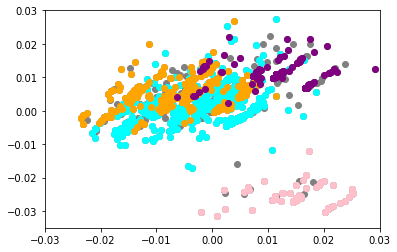

In [31]:
 aa=testing_data_and_labels_orig[testing_data_and_labels_orig['african-american'] > 0]
 aa_2d = testing_data_and_labels.loc[aa.index]
 c=testing_data_and_labels_orig[testing_data_and_labels_orig['caucasian'] > 0]
 c_2d = testing_data_and_labels.loc[c.index]
 h=testing_data_and_labels_orig[testing_data_and_labels_orig['hispanic'] > 0]
 h_2d = testing_data_and_labels.loc[h.index]
 o=testing_data_and_labels_orig[testing_data_and_labels_orig['other'] > 0]
 o_2d = testing_data_and_labels.loc[o.index]

x_min, x_max = -0.03,0.03
y_min, y_max = -0.035,0.03
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
plt.scatter(u[positive_labels,dim1], u[positive_labels,dim2], color='gray')
plt.scatter(u[negative_labels,dim1], u[negative_labels,dim2], color='gray')
plt.scatter(aa_2d['dim12'], aa_2d['dim13'], color='cyan')
plt.scatter(c_2d['dim12'], c_2d['dim13'], color='orange')
plt.scatter(h_2d['dim12'], h_2d['dim13'], color='purple')
plt.scatter(o_2d['dim12'], o_2d['dim13'], color='pink')
plt.show()

In [0]:
# testing_data_and_labels_orig.loc[misclassified_hb.index].to_csv(r'bias_orig_misclassified.csv', index=False)
testing_data_and_labels_orig.loc[misclassified_hv.index].to_csv(r'var_orig_misclassified.csv', index=False)
misclassified_orig = testing_data_and_labels_orig.loc[misclassified_hv.index]
# misclassified_orig_b= testing_data_and_labels_orig.loc[misclassified_hb.index]


finding the misclassified individuals

In [0]:
misclassified_aa = misclassified_orig.loc[misclassified_orig['african-american'] > 0 ]
misclassified_c = misclassified_orig.loc[misclassified_orig['caucasian'] > 0 ]
misclassified_h = misclassified_orig.loc[misclassified_orig['hispanic'] > 0 ]
misclassified_o = misclassified_orig.loc[misclassified_orig['other'] > 0 ]

In [0]:
#demographic misclassified individuals 
aa_misclass_2d = misclassified.loc[misclassified_aa.index]
c_misclass_2d = misclassified.loc[misclassified_c.index]
h_misclass_2d = misclassified.loc[misclassified_h.index]
o_misclass_2d = misclassified.loc[misclassified_o.index]

Plotting misclassified individuals in various contexts. Decision boundaries are of high variance model.
Demographics:
cyan = african american.
orange = white.
purple = hispanic.
pink = other.

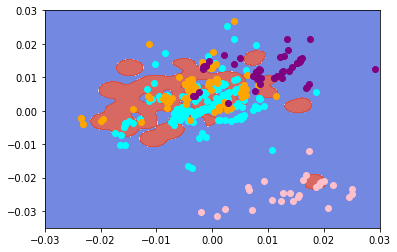

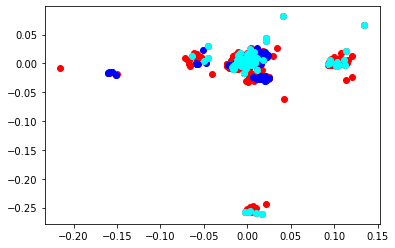

In [39]:

#plot decision boundaries and misclassified labelled by demographic
#for high variance model
#cyan = african american
#orange = white
#purple = hispanic
#pink = other

h = .00005
X=training_data.values
y=np.ravel(training_labels.values)
Z = classifiers[classifier_num_hv]
x_min, x_max = -0.03,0.03
y_min, y_max = -0.035,0.03
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = Z.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.scatter(aa_misclass_2d['dim12'], aa_misclass_2d['dim13'], color='cyan')
plt.scatter(c_misclass_2d['dim12'], c_misclass_2d['dim13'], color='orange')
plt.scatter(h_misclass_2d['dim12'], h_misclass_2d['dim13'], color='purple')
plt.scatter(o_misclass_2d['dim12'], o_misclass_2d['dim13'], color='pink')
plt.show()  

# plot one race demographic on top of training data 
plt.scatter(u[positive_labels,dim1], u[positive_labels,dim2], color='red')
plt.scatter(u[negative_labels,dim1], u[negative_labels,dim2], color='blue')
plt.scatter(aa_misclass_2d['dim12'], aa_misclass_2d['dim13'], color='cyan')
plt.show()

# plt.scatter(u[positive_labels,dim1], u[positive_labels,dim2], color='red')
# plt.scatter(u[negative_labels,dim1], u[negative_labels,dim2], color='blue')
# plt.scatter(c_misclass_2d['dim12'], c_misclass_2d['dim13'], color='orange')
# plt.show()

# plt.scatter(u[positive_labels,dim1], u[positive_labels,dim2], color='red')
# plt.scatter(u[negative_labels,dim1], u[negative_labels,dim2], color='blue')
# plt.scatter(h_misclass_2d['dim12'], h_misclass_2d['dim13'], color='purple')
# plt.show()

Plotting misclassified individuals with decision boundaries of high bias and high variance models 

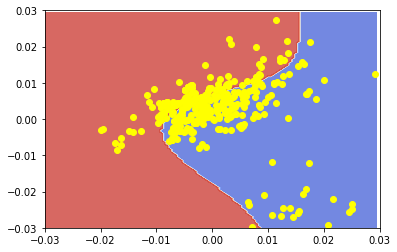

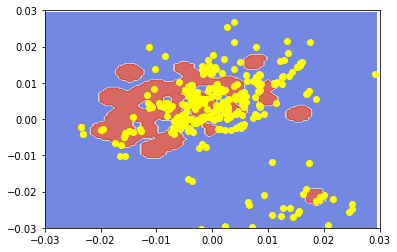

In [38]:
h = .0005
X=training_data.values
y=np.ravel(training_labels.values)
Z = classifiers[classifier_num_hb]
x_min, x_max = -0.03, 0.03
y_min, y_max = -0.03, 0.03
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = Z.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.scatter(misclassified_list[classifier_num_hb]['dim12'], misclassified_list[classifier_num_hb]['dim13'], color='yellow')
plt.show()

h = .0005
X=training_data.values
y=np.ravel(training_labels.values)
Z = classifiers[classifier_num_hv]
x_min, x_max = -0.03, 0.03
y_min, y_max =-0.03, 0.03
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = Z.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.axes(xlim =[x_min,x_max], ylim=[y_min,y_max])
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.scatter(misclassified_list[classifier_num_hv]['dim12'], misclassified_list[classifier_num_hv]['dim13'], color='yellow')
plt.show()

basic equalised odds plots 

In [0]:
if(equalised_odds):
  plt.plot(u[positive_labels,dim1], u[positive_labels,dim2], 'r.')
  plt.plot(u[negative_labels,dim1], u[negative_labels,dim2], 'b.')
  plt.scatter(misclassified_list_eq[eq_classifier_num_hb]['dim12'], misclassified_list_eq[eq_classifier_num_hb]['dim13'], color='yellow')
  plt.show()

  plt.plot(u[positive_labels,dim1], u[positive_labels,dim2], 'r.')
  plt.plot(u[negative_labels,dim1], u[negative_labels,dim2], 'b.')
  plt.scatter(misclassified_list_eq[eq_classifier_num_hv]['dim12'], misclassified_list_eq[eq_classifier_num_hv]['dim13'], color='yellow')
  plt.show()

  plt.axes(xlim=(-0.23,0.15), ylim=(-0.27,0.1))
  plt.scatter(misclassified_list_eq[eq_classifier_num_hb]['dim12'], misclassified_list_eq[eq_classifier_num_hb]['dim13'], color='yellow')
  plt.show()
  
  plt.axes(xlim=(-0.23,0.15), ylim=(-0.27,0.1))
  plt.scatter(misclassified_list_eq[eq_classifier_num_hv]['dim12'], misclassified_list_eq[eq_classifier_num_hv]['dim13'], color='yellow')
  plt.show()

Creating the appropriate plots to bias/variance errors. We plot: 

1.   Bias error vs Variance error
2.   Gamma value of RBF SVM vs Variance error
3.   Gamma value of RBF SVM vs Bias error


In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance_all(biases, variances, gammas, cs, degrees, losses, biases_eq, variances_eq, avg_losses_eq):   
  print("plotting bias/var") 
  plt.plot(biases, variances, 'y.')
  plt.plot(biases_eq, variances_eq, 'g.')                                                                                            
  plt.title('bias vs variance errors')                                     
  plt.xlabel('bias')                                                       
  plt.ylabel('variance')                                                   
  plt.show()

  plt.plot(gammas, variances, 'y.')
  plt.plot(gammas, variances_eq, 'g.')
  plt.xscale('log')                                              
  plt.title('RBF SVM \n gamma size vs variance errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('variance')                                                   
  plt.show()                                                            

  plt.plot(gammas, biases, 'y.')
  plt.plot(gammas, biases_eq, 'g.')
  plt.xscale('log')                                                             
  plt.title('RBF SVM\n gamma size vs bias errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('bias')                                                   
  plt.show()            

  plt.plot(gammas, losses, 'y.')
  plt.plot(gammas, avg_losses_eq, 'g.')                          
  plt.xscale('log')                                                             
  plt.title('RBF SVM \n gamma size vs total error')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('error')                                                   
  plt.show()   


In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance(biases, variances, gammas, cs, degrees, losses):   

  print("plotting bias/var") 
  plt.scatter(biases, variances)                                              
  plt.title('bias vs variance errors')                                     
  plt.xlabel('bias')                                                       
  plt.ylabel('variance')                                                   
  plt.show()

  plt.scatter(gammas, variances)
  plt.xscale('log')                                              
  plt.title('RBF SVM \n gamma size vs variance errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('variance')                                                   
  plt.show()                                                            

  plt.scatter(gammas, biases)                               
  plt.xscale('log')                                                             
  plt.title('RBF SVM\n gamma size vs bias errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('bias')                                                   
  plt.show()            

  plt.scatter(gammas, losses)                               
  plt.xscale('log')                                                             
  plt.title('RBF SVM \n gamma size vs total error')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('error')                                                   
  plt.show()   

before fairness correction:
plotting bias/var


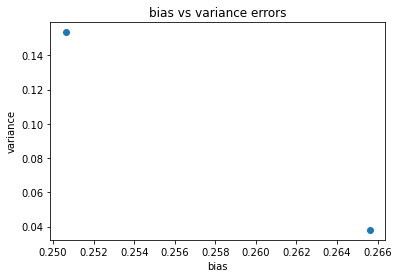

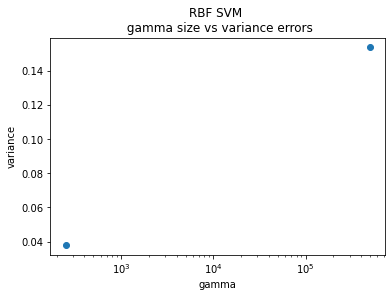

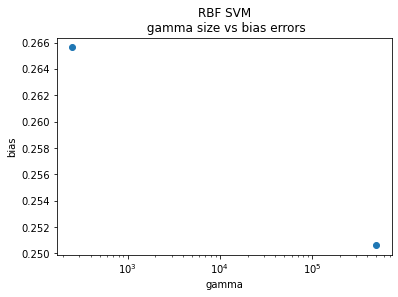

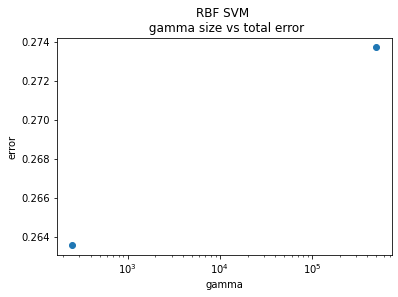

In [44]:
print("before fairness correction:")
plot_bias_variance(biases, variances, gammas, cs, degrees, avg_losses)
if(equalised_odds):
  print("after fairness correction:")
  plot_bias_variance(biases_eq, variances_eq, gammas, cs, degrees, avg_losses_eq)
  plot_bias_variance_all(biases, variances, gammas, cs, degrees, avg_losses, biases_eq, variances_eq, avg_losses_eq)